In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

In [2]:
# Method to get lightcurve data
def get_lightcurve(filename):
    lc_data = ascii.read(filename)

    filter_id = lc_data['fid'][0]
    epoch = lc_data['obsmjd']
    mag = lc_data['mag_autocorr']
    mag_err = lc_data['magerr_auto']
    sn_type = lc_data['type_01'][0]
    epoch = np.asarray(epoch)
    mag = np.asarray(mag)
    mag_err = np.asarray(mag_err)

    if filter_id == 1:
        mag_label = '$m_g$'
    elif filter_id == 2:
        mag_label = '$m_R$'
    
    return epoch, mag, mag_err, sn_type, mag_label

In [3]:
# Method to plot lightcurve
def plot_lightcurve(x, y, yerr, sn_type, y_label):
    plt.figure(figsize=(8,5.5))
    plt.errorbar(x, y, yerr = yerr, lw=1, capsize=1, color='#000099', linestyle='None', marker='.')
    plt.gca().invert_yaxis()
    plt.xlabel('MJD')
    plt.title('SN2011dh: type ' + str(sn_type))
    plt.ylabel(y_label)

In [46]:
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ExpSineSquared
from sklearn.gaussian_process import GaussianProcessRegressor

# Def. method to iteratively run GPR process
# Arguments:
# - x_in - independent variable
# - y_in - dependent variable
# - kernel - kernel function to use for GPR
#
# Returns:
# hyper_vector - array containing log likelihood and hyperparameters

def do_GPR(x_in, y_in):
    # Define range of input space to predict over
    x_min = x_in.min() - 20
    x_max = x_in.max() + 20
    
    # Mesh the input space for evaluations of the real function, the prediction and
    # its MSE
    x_space = np.atleast_2d(np.linspace(x_min, x_max, 1000)).T
    x_fit = np.atleast_2d(x_in).T
    
    k_RBF = RBF(length_scale=1e2, length_scale_bounds=(1e-2, 1e5))
    k_exp = (Matern(length_scale=1e2, length_scale_bounds=(1e-2, 1e6), nu=0.5))
    k_sine = ExpSineSquared(length_scale=1e2, length_scale_bounds=(1e-2, 1e5), periodicity=1e4, periodicity_bounds=(1e3, 5e5))
    k_noise = WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1e5))

    # Matern kernel with nu = 0.5 is equivalent to the exponential kernel
    # Define kernel function
    kernel = 1.0 * k_RBF + 1.0*(k_exp*k_sine) + k_noise
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=10, normalize_y=True)
    
    # Fit to data using Maximum Likelihood Estimation of the parameters
    gpr.fit(x_fit, y_in)

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, y_pred_sigma = gpr.predict(x_space, return_std=True)
    
    # Get log likelihood and hyperparameters
    log_likelihood = gpr.log_marginal_likelihood()
    hyper_params = gpr.kernel_
    
    hyper_vector = []
    hyper_vector.append(log_likelihood)
    params = hyper_params.get_params()
    for i, key in enumerate(sorted(params)):
        if i in (3,6,10,14,18,20,23):
            #print(i, "%s : %s" % (key, params[key]))
            hyper_vector.append(params[key])
    
    return x_space, y_pred, y_pred_sigma, hyper_vector

### Composite kernel used for GPR fitting

Component kernels:

$$ k_{\textrm{RBF}} = \exp\left(-\frac{1}{2}\left[\frac{\vert x_i - x_j \vert}{l_1}\right]^2\right) $$

$$ k_{\textrm{exp}} = \exp\left(-\frac{\vert x_i - x_j \vert}{l_2}\right) $$

$$ k_{\textrm{sine}} = \exp\left( -2\sin^2\left[ \frac{\pi}{P}\frac{\vert x_i - x_j \vert}{l_3}\right] \right) $$

$$ k_{\textrm{noise}} = \sigma_n \delta_{x_i, x_j} $$

Composite kernel:

$$  \omega_1 k_{\textrm{RBF}} + \omega_2 k_{\textrm{exp}} k_{\textrm{sine}} + k_{\textrm{noise}} $$

Hyperparameters:

- $\omega_1$, weighting of $k_{\textrm{RBF}}$, [2] in above array
- $l_1$, length scale of $k_{\textrm{RBF}}$, [6] in above array
- $\omega_2$, weighting of $k_{\textrm{exp}} k_{\textrm{sine}}$, [9] in above array
- $l_2$, length scale of $k_{\textrm{exp}}$, [14] in above array
- $l_3$, length scale of $k_{\textrm{sine}}$, [18] in above array
- $P$, periodicity of $k_{\textrm{sine}}$, [20] in above array
- $\sigma_n$, noise level of $k_{\textrm{noise}}$, [23] in above array

In [8]:
# Method to plot GPR fit and training data
def plot_GPR(x_in, y_in, y_err, x_space, y_pred, y_pred_sigma):
    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    plt.figure(figsize=(8, 5.5))
    plt.errorbar(x_in, y_in, yerr = y_err, lw=1, capsize=1, color='#b30000', linestyle='None', marker='.', label='Data')
    plt.plot(x_space, y_pred, 'b-', label=u'Prediction')
    plt.fill(np.concatenate([x_space, x_space[::-1]]),
             np.concatenate([y_pred - 1.9600 * y_pred_sigma,
                            (y_pred + 1.9600 * y_pred_sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    plt.xlabel('MJD')
    plt.ylabel(mag_label)
    plt.gca().invert_yaxis()
    plt.legend(loc='lower left')
    plt.show()

/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


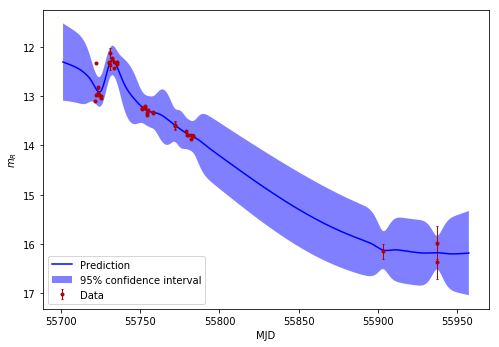

[2.7505364073479015, 0.058295064379393816, 4.211223500660969, 5.1164700433772525, 999999.9999999995, 1.0, 1025.3798612790267, 0.020556276238499187]


In [43]:
epoch, mag, mag_err, sn_type, mag_label = get_lightcurve('SN2011dh.tbl')
x_space, y_pred, y_pred_sigma, theta = do_GPR(epoch, mag)
plot_GPR(epoch, mag, mag_err, x_space, y_pred, y_pred_sigma)
print(theta)

/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


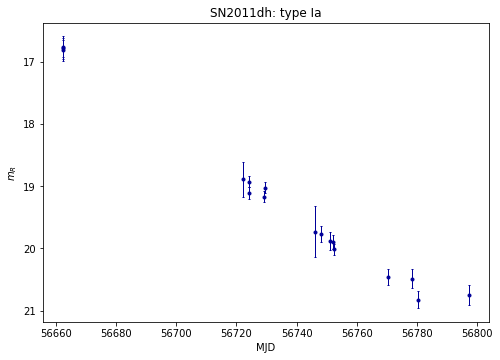

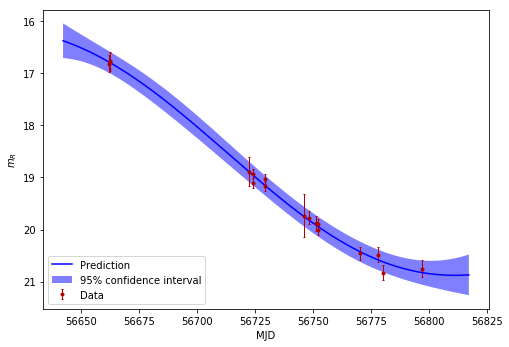

[5.662743403998297, 4.995207408112125, 104.82221303992476, 9.999999999999997e-06, 999999.9999999995, 152.00000261791317, 2174.1097380861556, 0.008378660833627639]


In [44]:
# Test for new lightcurve data
SN_toget = 'SN2014E.tbl'
epoch2, mag2, mag_err2, sn_type2, mag_label2 = get_lightcurve(SN_toget)
plot_lightcurve(epoch2, mag2, mag_err2, sn_type2, mag_label2)
x_space2, y_pred2, y_pred_sigma2, theta2 = do_GPR(epoch2, mag2)
plot_GPR(epoch2, mag2, mag_err2, x_space2, y_pred2, y_pred_sigma2)
print(theta2)

/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'funcalls': 70, 'warnflag': 2, 'nit': 22, 'grad': array([ 2.35952371e-05, -4.07343257e-05,  1.60133081e-03,  1.66128579e-05,
       -7.29677624e-16, -7.29673558e-16,  1.45485560e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  ConvergenceWarning)


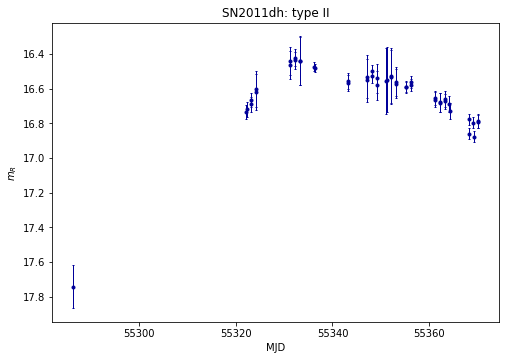

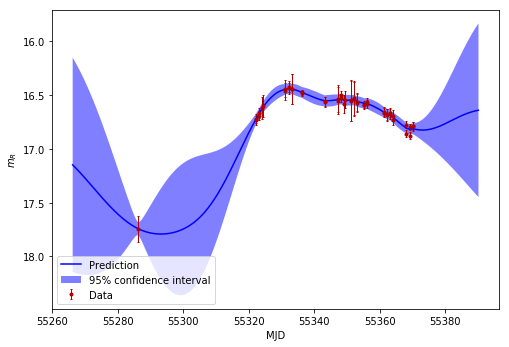

[84.43651985050195, 0.28975758708884514, 14.978202560296545, 0.07048312306356877, 797.8772929055458, 1.5417993903600613, 103728.78152063781, 0.0004906658876304907]


In [47]:
epoch2, mag2, mag_err2, sn_type2, mag_label2 = get_lightcurve('PTF10gva.tbl')
plot_lightcurve(epoch2, mag2, mag_err2, sn_type2, mag_label2)
x_space2, y_pred2, y_pred_sigma2, theta2 = do_GPR(epoch2, mag2)
plot_GPR(epoch2, mag2, mag_err2, x_space2, y_pred2, y_pred_sigma2)
print(theta2)

/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


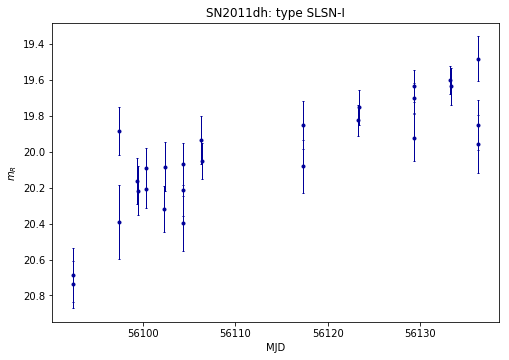

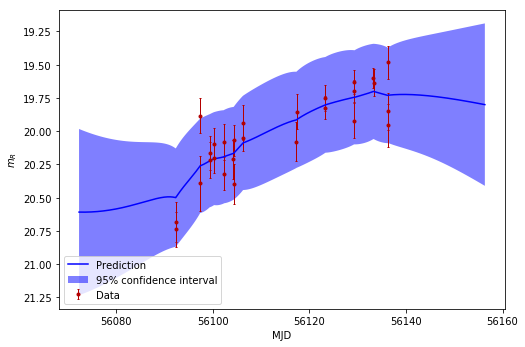

[3.661272953294862, 0.1998412330529326, 29.93542879778328, 0.006210357324867763, 2.8924857914310147, 3.732738718628209, 2719.2563159607917, 0.02769173447099493]


In [33]:
epoch2, mag2, mag_err2, sn_type2, mag_label2 = get_lightcurve('PTF12gty.tbl')
plot_lightcurve(epoch2, mag2, mag_err2, sn_type2, mag_label2)
x_space2, y_pred2, y_pred_sigma2, theta2 = do_GPR(epoch2, mag2)
plot_GPR(epoch2, mag2, mag_err2, x_space2, y_pred2, y_pred_sigma2)
print(theta2)

/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


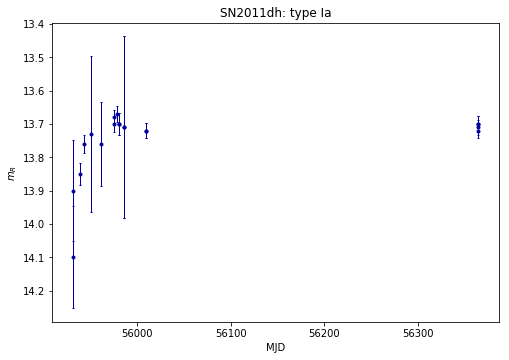

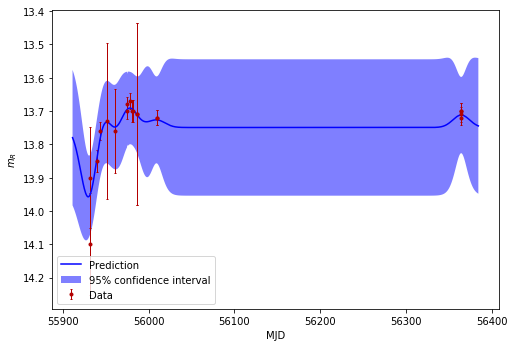

[23.594448488914754, 0.00835259570458246, 9.847291901565429, 0.002546314010449346, 0.010000000000000004, 289.12802653982834, 7275.6576045634065, 9.999999999999997e-06]


In [34]:
epoch2, mag2, mag_err2, sn_type2, mag_label2 = get_lightcurve('PTF12alp.tbl')
plot_lightcurve(epoch2, mag2, mag_err2, sn_type2, mag_label2)
x_space2, y_pred2, y_pred_sigma2, theta2 = do_GPR(epoch2, mag2)
plot_GPR(epoch2, mag2, mag_err2, x_space2, y_pred2, y_pred_sigma2)
print(theta2)

/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


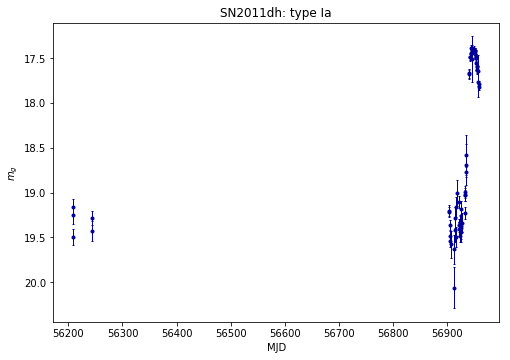

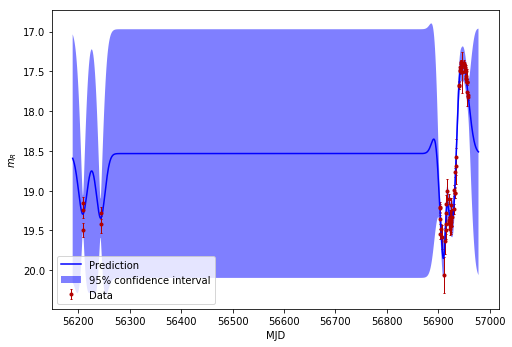

[26.027939927286745, 0.6054400703010305, 8.815053493198391, 0.020906416956499876, 999999.9999999995, 0.010000000000000004, 2194.4993482007303, 0.009859884662183118]


In [48]:
epoch2, mag2, mag_err2, sn_type2, mag_label2 = get_lightcurve('iPTF14gjh.tbl')
plot_lightcurve(epoch2, mag2, mag_err2, sn_type2, mag_label2)
x_space2, y_pred2, y_pred_sigma2, theta2 = do_GPR(epoch2, mag2)
plot_GPR(epoch2, mag2, mag_err2, x_space2, y_pred2, y_pred_sigma2)
print(theta2)

/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


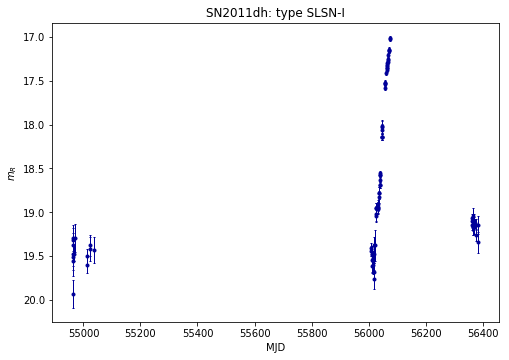

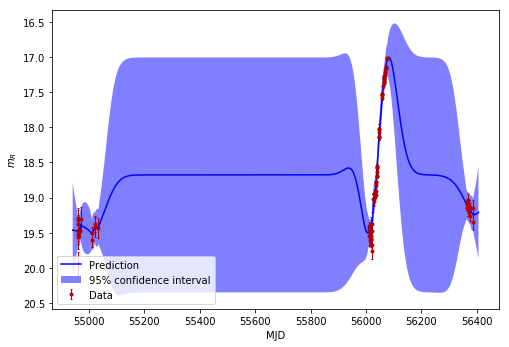

[48.84277569448031, 0.7127711074147484, 38.52246310519048, 0.007803567024605615, 5.009975807486015, 0.018801404937085608, 114497.22146249565, 0.007860503495365167]


In [49]:
epoch2, mag2, mag_err2, sn_type2, mag_label2 = get_lightcurve('PTF12dam.tbl')
plot_lightcurve(epoch2, mag2, mag_err2, sn_type2, mag_label2)
x_space2, y_pred2, y_pred_sigma2, theta2 = do_GPR(epoch2, mag2)
plot_GPR(epoch2, mag2, mag_err2, x_space2, y_pred2, y_pred_sigma2)
print(theta2)

/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


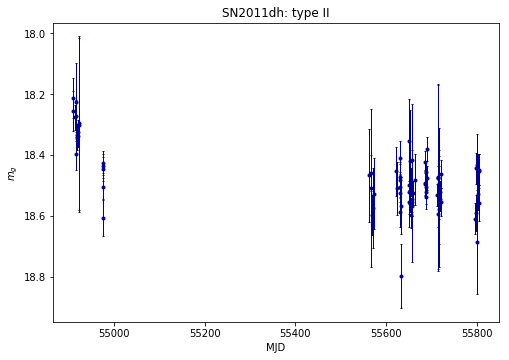

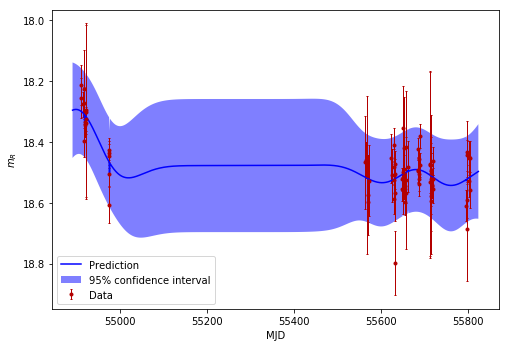

[90.55040872346349, 0.00773743950652448, 53.1786658150096, 0.00472915490898925, 0.01602593973335645, 6602.092267492379, 21226.186676022102, 9.999999999999997e-06]


In [26]:
epoch2, mag2, mag_err2, sn_type2, mag_label2 = get_lightcurve('SN2009bj.tbl')
plot_lightcurve(epoch2, mag2, mag_err2, sn_type2, mag_label2)
x_space2, y_pred2, y_pred_sigma2, theta2 = do_GPR(epoch2, mag2)
plot_GPR(epoch2, mag2, mag_err2, x_space2, y_pred2, y_pred_sigma2)
print(theta2)

/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


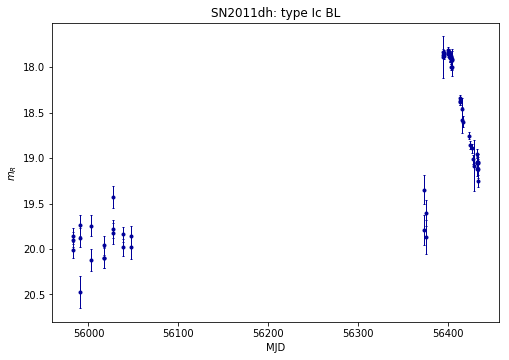

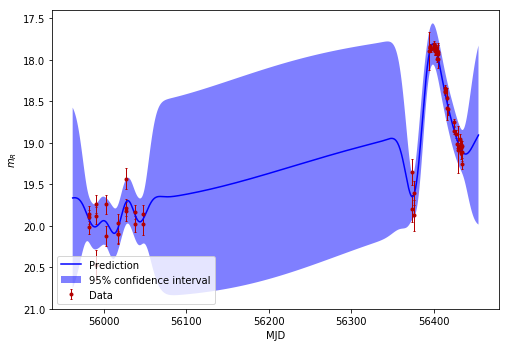

[19.399436088345908, 0.45209023249014624, 222.25850503780777, 0.2633064711268439, 999999.9999999995, 0.010018851549591215, 7352.901579283869, 0.014929033183840411]


In [27]:
epoch2, mag2, mag_err2, sn_type2, mag_label2 = get_lightcurve('SN2013bn.tbl')
plot_lightcurve(epoch2, mag2, mag_err2, sn_type2, mag_label2)
x_space2, y_pred2, y_pred_sigma2, theta2 = do_GPR(epoch2, mag2)
plot_GPR(epoch2, mag2, mag_err2, x_space2, y_pred2, y_pred_sigma2)
print(theta2)

/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


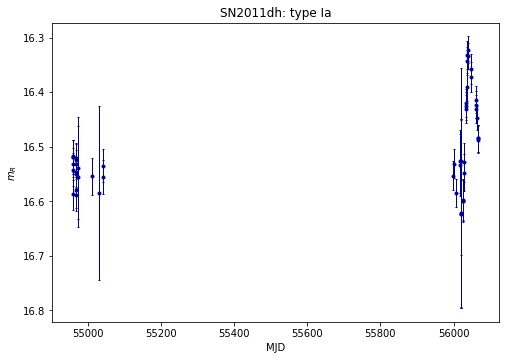

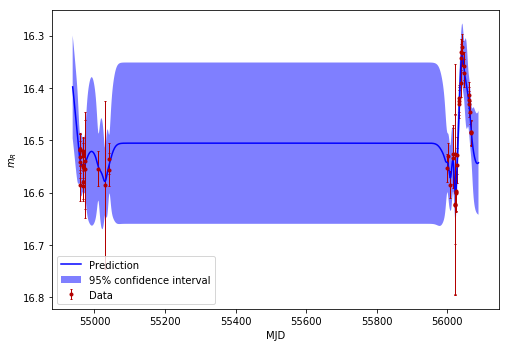

[94.02194259822102, 0.0011472508225392184, 4.284502980993042, 0.004465621810321207, 999999.9999999995, 0.07593538410242037, 1116.478623034754, 0.0005644689785151292]


In [28]:
epoch2, mag2, mag_err2, sn_type2, mag_label2 = get_lightcurve('PTF12dhl.tbl')
plot_lightcurve(epoch2, mag2, mag_err2, sn_type2, mag_label2)
x_space2, y_pred2, y_pred_sigma2, theta2 = do_GPR(epoch2, mag2)
plot_GPR(epoch2, mag2, mag_err2, x_space2, y_pred2, y_pred_sigma2)
print(theta2)